In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
)

In [28]:
# Load data
df_sensor = pd.read_csv("datasets/assignTTSWING_sensor_only.csv")
X = df_sensor.drop(columns=['playYears'])
y = df_sensor['playYears']
classes = np.unique(y)
n_classes = len(classes)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:

# K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
accuracies, precisions, recalls, f1s = [], [], [], []
conf_matrices = []
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# K-Fold evaluation
for fold, (train_index, test_index) in enumerate(skf.split(X_scaled, y), 1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LogisticRegression(
        penalty=None,
        solver='lbfgs',
        multi_class='multinomial',
        class_weight='balanced',
        max_iter=1000
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    # Store performance metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    # ROC/AUC: Binarize labels
    y_test_bin = label_binarize(y_test, classes=classes)

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        fpr_dict.setdefault(i, []).append(fpr)
        tpr_dict.setdefault(i, []).append(tpr)
        roc_auc_dict.setdefault(i, []).append(auc(fpr, tpr))

# === AVERAGE METRICS ===
print("\n===== Average Results over 5 Folds =====")
print(f"Mean Accuracy:  {np.mean(accuracies):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall:    {np.mean(recalls):.4f}")
print(f"Mean F1 Score:  {np.mean(f1s):.4f}")

c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\gavin\miniconda3\envs\data7001\Lib\site-packages\sklearn\linear_model\_logistic.py


===== Average Results over 5 Folds =====
Mean Accuracy:  0.5006
Mean Precision: 0.5183
Mean Recall:    0.5637
Mean F1 Score:  0.5016


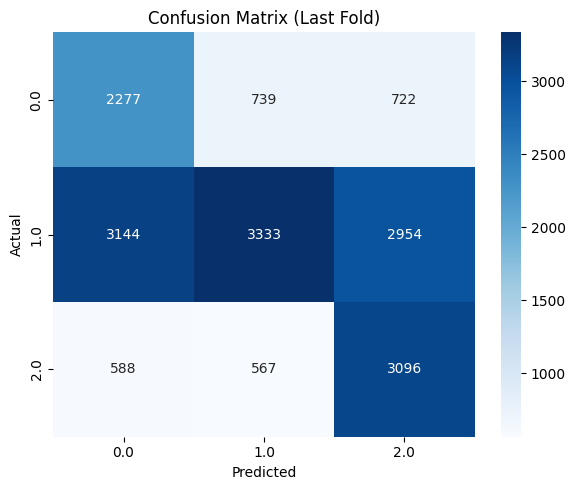

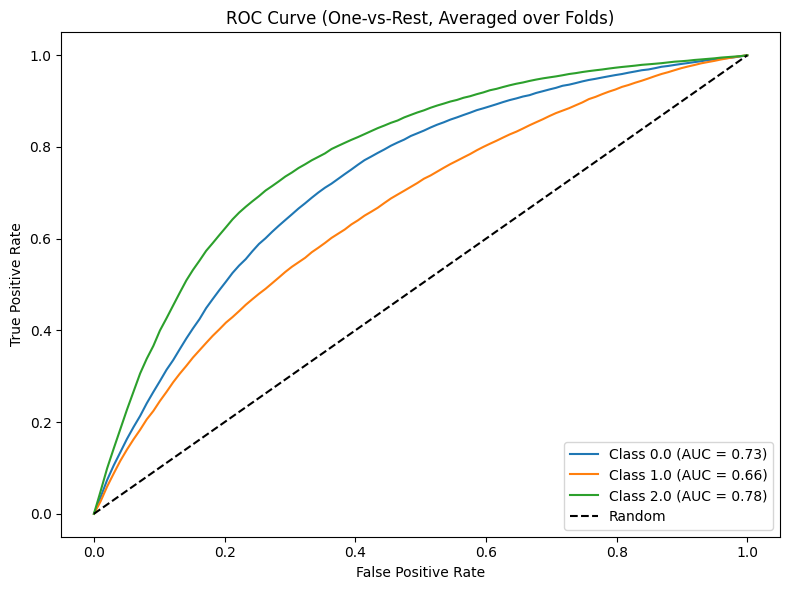

In [33]:


# === CONFUSION MATRIX (last fold as example) ===
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrices[-1], annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Last Fold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === ROC CURVE for each class ===
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    mean_fpr = np.linspace(0, 1, 100)
    interp_tprs = []
    for fpr, tpr in zip(fpr_dict[i], tpr_dict[i]):
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)
    mean_tpr = np.mean(interp_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"Class {classes[i]} (AUC = {mean_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest, Averaged over Folds)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()